In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
print(torch.cuda.is_available())

True


## Prepare data

In [3]:
df = pd.read_csv('merge_train.csv',parse_dates=['date'])

In [4]:
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekdays'] = df['date'].dt.dayofweek  # 1 for weekend, 0 for weekday
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute




df['Forecast_difference_0.5 hour future'] = df['Forecast_Roof_0.5 hour future'] - df['Forecast_Demand_0.5 hour future']
df["Forecast_ratio_0.5 hour future"] = df['Forecast_Roof_0.5 hour future'] / df['Forecast_Demand_0.5 hour future']
df.set_index('date', inplace=True)

In [5]:

df = df.drop(columns=['Region', 'Actual_Roof_OPOWER', 'Actual_Roof_LASTCHANGED'])


In [6]:
X = df.drop('Price', axis=1)
y = df['Price']

train_end_date = pd.to_datetime("2024-04-30 23:59:59")
val_end_date = pd.to_datetime("2024-05-31 23:59:59")
test_start_date = pd.to_datetime("2024-06-01 00:00:00")


X_train = X[X.index <= train_end_date]
X_val = X[(X.index > train_end_date) & (X.index <= val_end_date)]
X_test = X[X.index >= test_start_date]

y_train = y[y.index <= train_end_date]
y_val = y[(y.index > train_end_date) & (y.index <= val_end_date)]
y_test = y[y.index >= test_start_date]

In [37]:
import torch.nn as nn
import torch.nn.functional as F

class AttentionLayer(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Linear(hidden_size, 1)
    
    def forward(self, hidden_states):
        # hidden_states: [batch_size, seq_length, hidden_size]
        attention_scores = self.attention(hidden_states)  # [batch_size, seq_length, 1]
        attention_weights = torch.softmax(attention_scores, dim=1)
        context_vector = torch.sum(attention_weights * hidden_states, dim=1)  # [batch_size, hidden_size]
        return context_vector

class LSTMAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0.3):
        super(LSTMAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_rate)
        
        self.attention = AttentionLayer(hidden_size)  # 修改为 hidden_size
        
        self.fc1 = nn.Linear(hidden_size, 128)  # 修改为 hidden_size
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 1)
        
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # lstm_out: [batch_size, seq_length, hidden_size]
        attn_out = self.attention(lstm_out)  # attn_out: [batch_size, hidden_size]
        # print(attn_out.shape)  # 可以打印检查维度
        fc1_out = F.relu(self.fc1(attn_out))
        fc1_out = self.dropout(fc1_out)
        fc2_out = F.relu(self.fc2(fc1_out))
        fc2_out = self.dropout(fc2_out)
        output = self.fc3(fc2_out)
        return output


In [38]:
# 區塊 1：數據標準化
from sklearn.preprocessing import StandardScaler

# 對特徵進行標準化
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# 對目標變量進行標準化
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# 區塊 2：準備序列數據
def prepare_data(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 10

X_train_seq, y_train_seq = prepare_data(X_train_scaled, y_train_scaled, seq_length)
X_val_seq, y_val_seq = prepare_data(X_val_scaled, y_val_scaled, seq_length)
X_test_seq, y_test_seq = prepare_data(X_test_scaled, y_test_scaled, seq_length)

# 區塊 3：轉換為張量
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val_seq, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_seq, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32).to(device)


In [39]:
# 區塊 5：設置訓練參數
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader

# 超參數
input_size = X_train_tensor.shape[2]  
hidden_size = 160
num_layers = 3
num_epochs = 100
batch_size = 32
learning_rate = 0.001

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 區塊 6：初始化模型
def weighted_mse_loss(preds, targets):
    weights = torch.ones_like(targets)
    # 定义极端值的阈值，例如高于某个值的为极端值
    extreme_threshold = torch.quantile(targets, 0.95)
    weights[targets >= extreme_threshold] = 2.0  # 对极端值赋予更大的权重
    loss = weights * (preds - targets) ** 2
    return loss.mean()

model = LSTMAttention(input_size, hidden_size, num_layers).to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)


c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [40]:
# 區塊 7：訓練模型
import numpy as np
import matplotlib.pyplot as plt

train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_X.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            val_loss += loss.item() * batch_X.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')


Epoch 1/100, Train Loss: 0.115915, Val Loss: 0.097048
Epoch 2/100, Train Loss: 0.108379, Val Loss: 0.095026
Epoch 3/100, Train Loss: 0.105970, Val Loss: 0.094633
Epoch 4/100, Train Loss: 0.104865, Val Loss: 0.094318
Epoch 5/100, Train Loss: 0.103373, Val Loss: 0.093309
Epoch 6/100, Train Loss: 0.102793, Val Loss: 0.094140
Epoch 7/100, Train Loss: 0.101836, Val Loss: 0.093284
Epoch 8/100, Train Loss: 0.101188, Val Loss: 0.092642
Epoch 9/100, Train Loss: 0.100859, Val Loss: 0.094101
Epoch 10/100, Train Loss: 0.100101, Val Loss: 0.094494
Epoch 11/100, Train Loss: 0.099787, Val Loss: 0.093035
Epoch 12/100, Train Loss: 0.099399, Val Loss: 0.091237
Epoch 13/100, Train Loss: 0.099089, Val Loss: 0.092206
Epoch 14/100, Train Loss: 0.098516, Val Loss: 0.090788
Epoch 15/100, Train Loss: 0.098222, Val Loss: 0.091618
Epoch 16/100, Train Loss: 0.097760, Val Loss: 0.090615
Epoch 17/100, Train Loss: 0.097635, Val Loss: 0.090682
Epoch 18/100, Train Loss: 0.097059, Val Loss: 0.090078
Epoch 19/100, Train

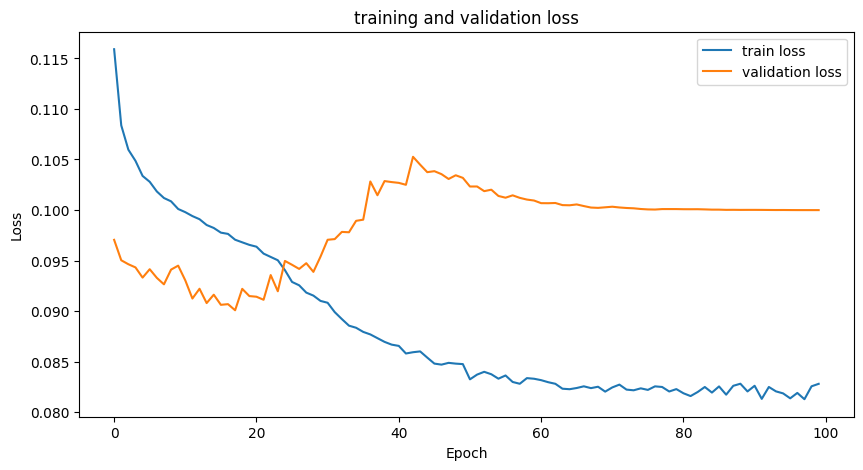

In [41]:
# 區塊 8：可視化損失曲線
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('training and validation loss')
plt.legend()
plt.show()


In [42]:

with torch.no_grad():
    predictions = model(X_test_tensor).cpu().numpy().squeeze()
    y_test_actual = y_test_tensor.cpu().numpy().squeeze()
    # 单元格 3：反标准化
# 将预测结果和真实值从标准化尺度转换回原始尺度
    predictions_rescaled = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()
    y_test_rescaled = scaler_y.inverse_transform(y_test_actual.reshape(-1, 1)).flatten()

    


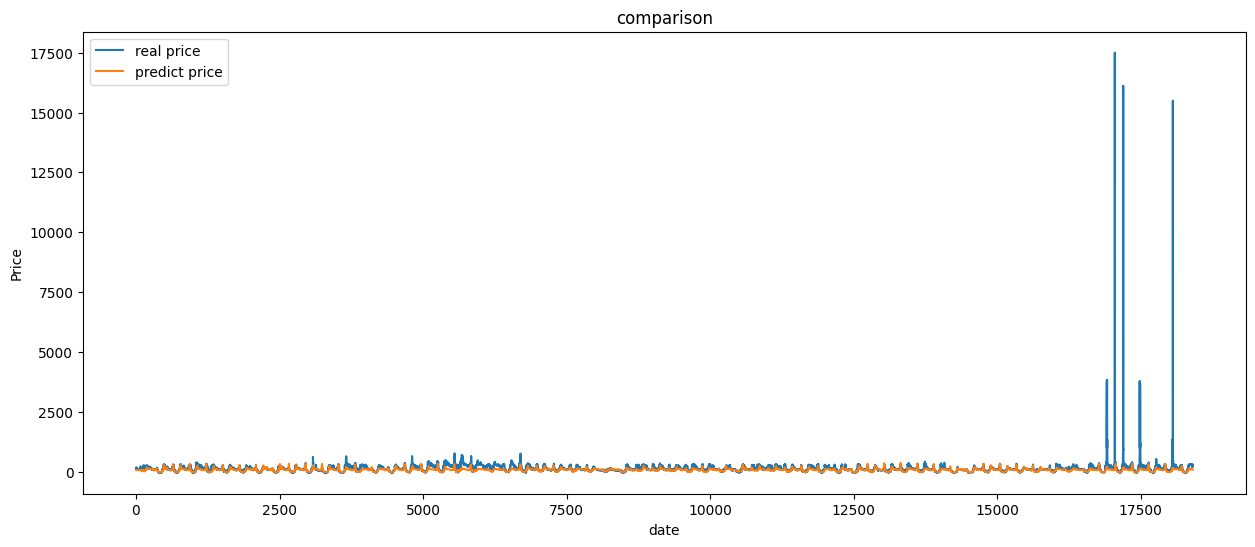

In [43]:

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(y_test_rescaled, label='real price')
plt.plot(predictions_rescaled, label='predict price')
plt.xlabel('date')
plt.ylabel('Price')
plt.title('comparison')
plt.legend()
plt.show()


In [44]:
results_df = pd.DataFrame({
    'Actual': y_test_rescaled,
    'Predicted': predictions_rescaled
}, index=y_test.index[seq_length:])

In [45]:
# 单元格 2：定义绘图函数
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, HourLocator, DateFormatter
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def plot_three_day_comparison(data, start_date, end_date):
    period_data = data.loc[start_date:end_date]
    
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(period_data.index, period_data['Actual'], label='Actual price', marker='o', markersize=4)
    ax.plot(period_data.index, period_data['Predicted'], label='predict price', marker='o', markersize=4)
    
    ax.set_title(f'（{start_date.strftime("%Y-%m-%d %H:%M")} to {end_date.strftime("%Y-%m-%d %H:%M")}）')
    ax.set_xlabel('date')
    ax.set_ylabel('Price')
    ax.legend()
    

    ax.xaxis.set_major_locator(HourLocator(interval=6))
    ax.xaxis.set_major_formatter(DateFormatter('%m-%d %H:%M'))
    plt.xticks(rotation=45)
    
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    

    mse = mean_squared_error(period_data['Actual'], period_data['Predicted'])
    mae = mean_absolute_error(period_data['Actual'], period_data['Predicted'])
    rmse = np.sqrt(mse)
    r2 = r2_score(period_data['Actual'], period_data['Predicted'])
    
    metrics_text = f'MSE: {mse:.4f}\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}\n$R^2$: {r2:.4f}'
    plt.text(0.02, 0.98, metrics_text, transform=ax.transAxes, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.show()


C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  plt.tight_layout()
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


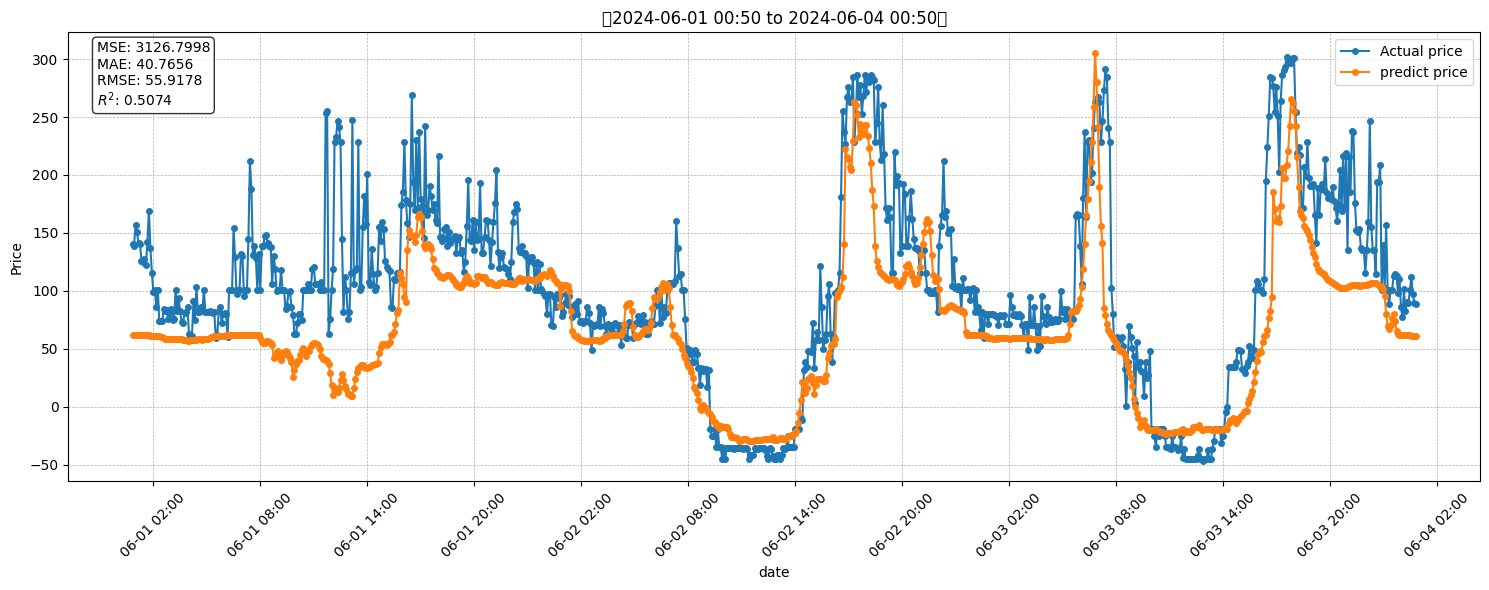

C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  plt.tight_layout()
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


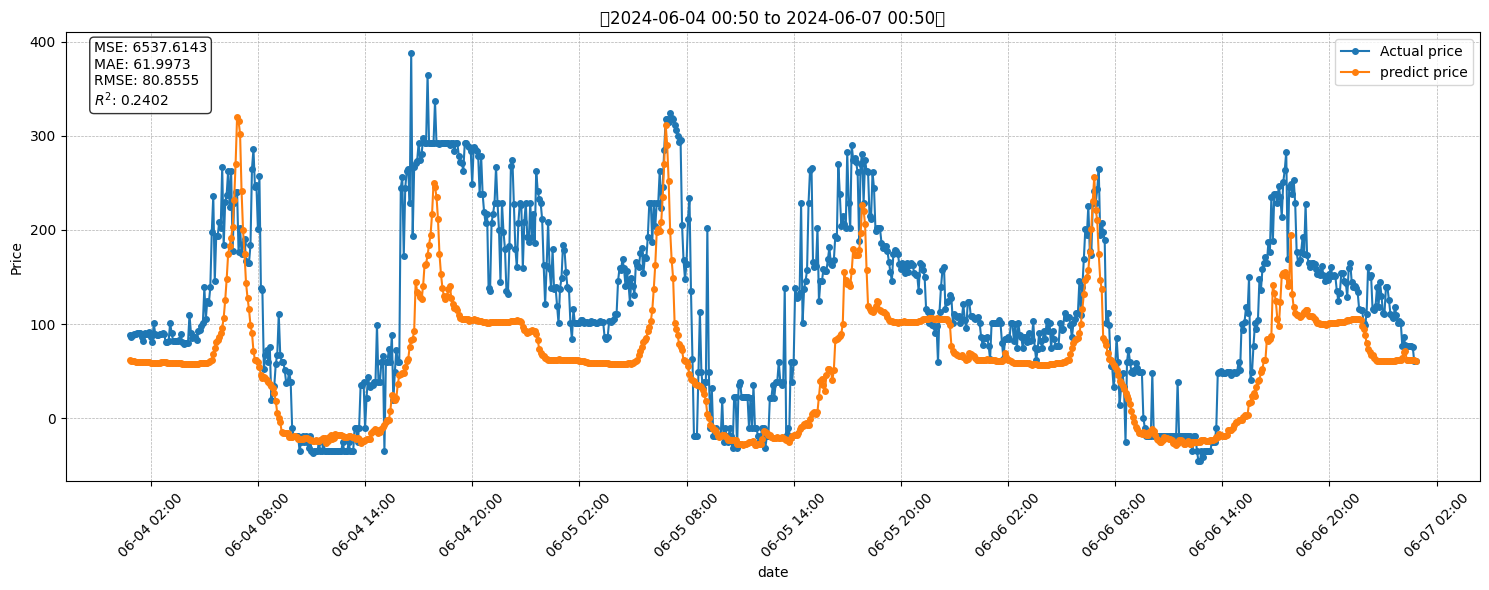

C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  plt.tight_layout()
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


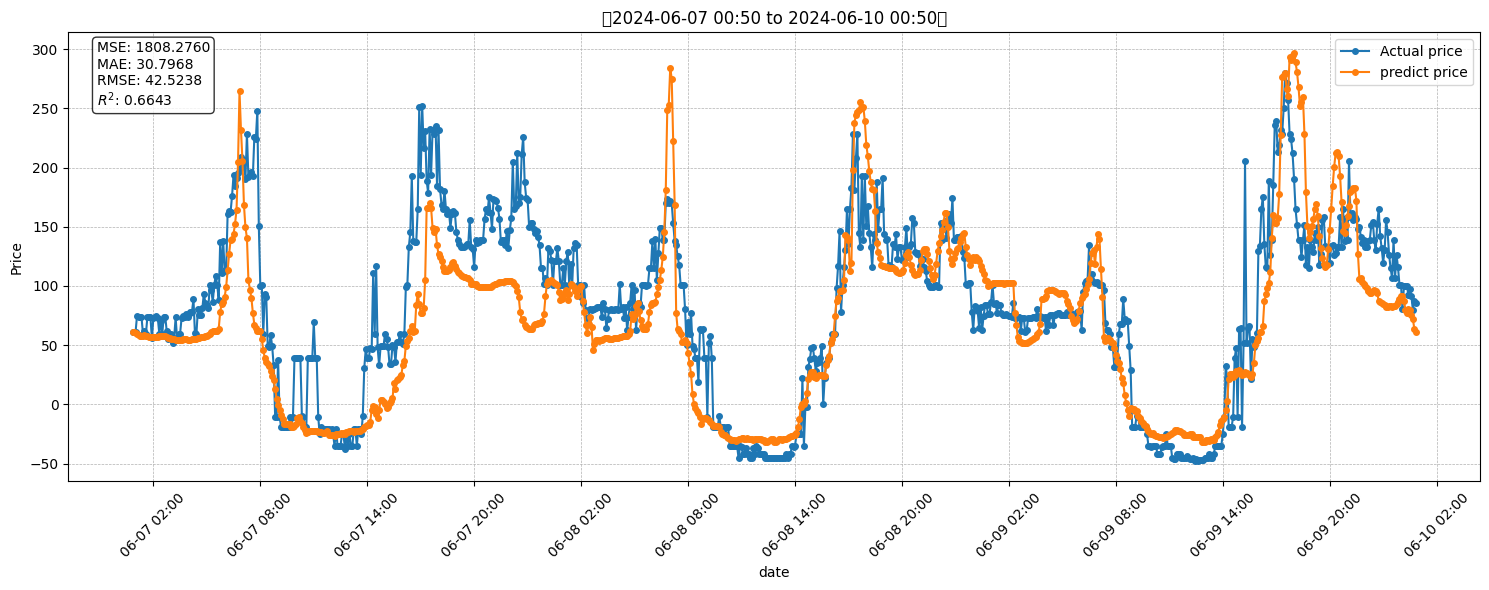

C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  plt.tight_layout()
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


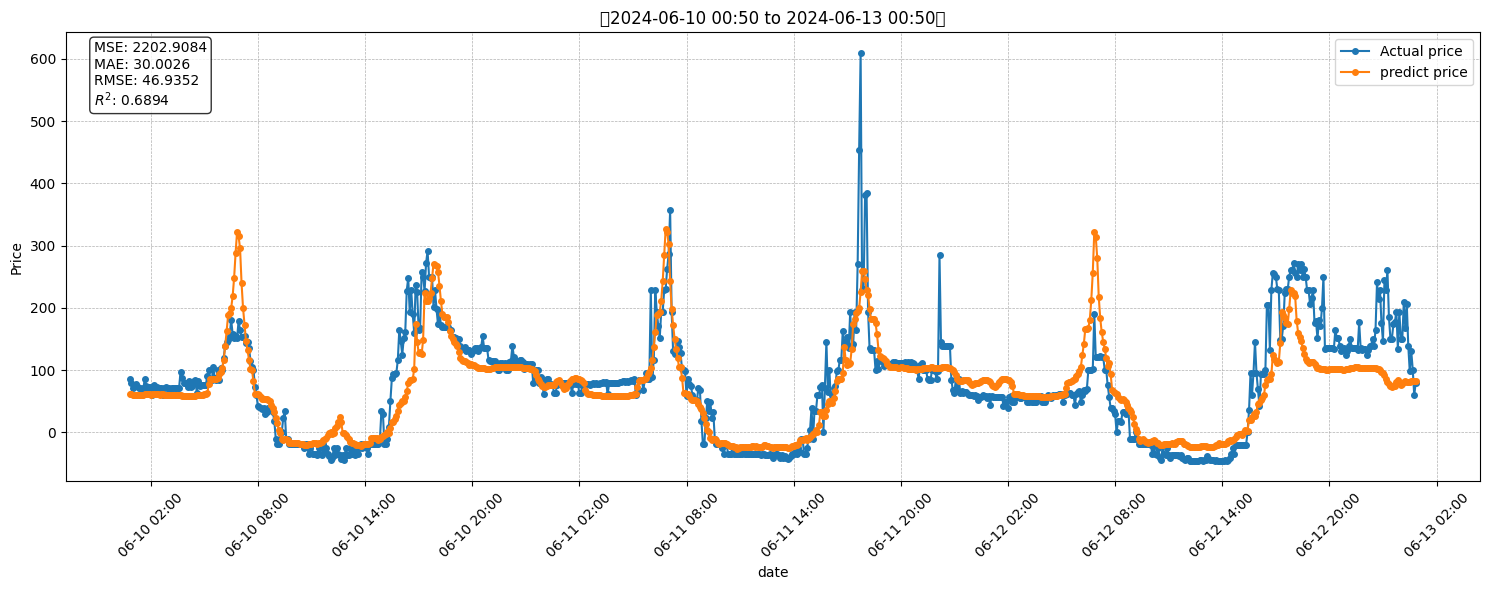

C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  plt.tight_layout()
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


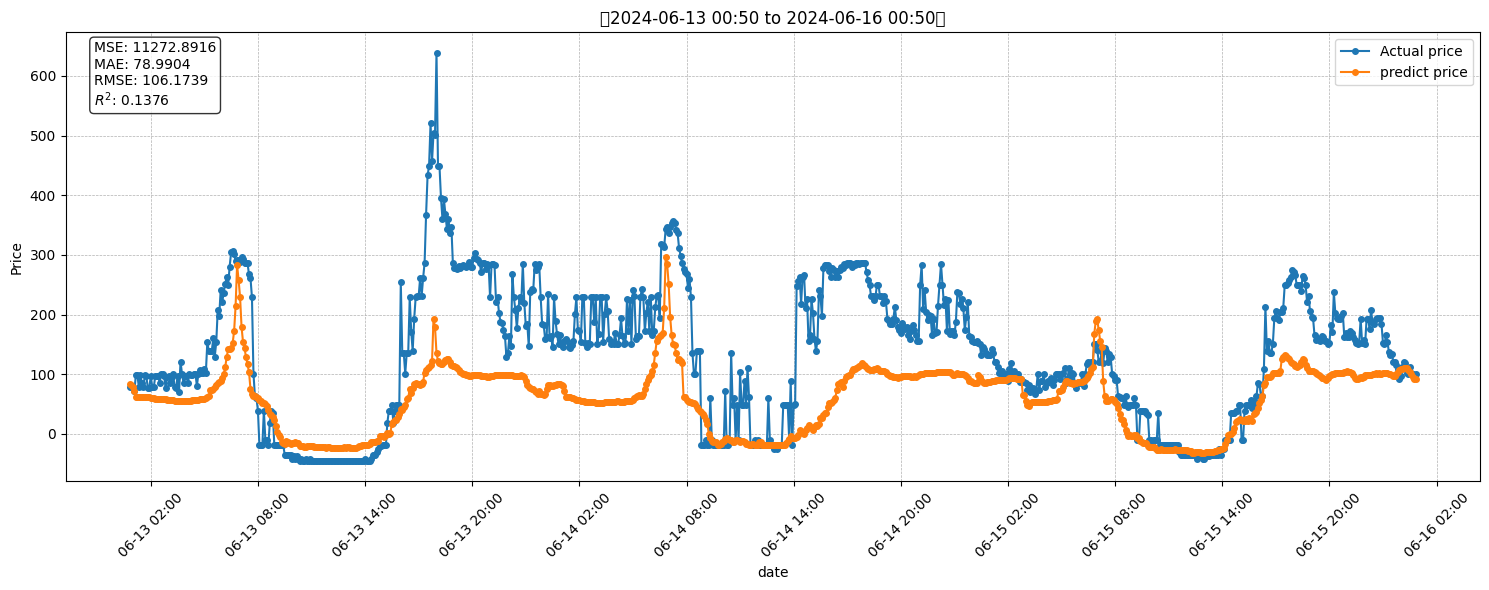

C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  plt.tight_layout()
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


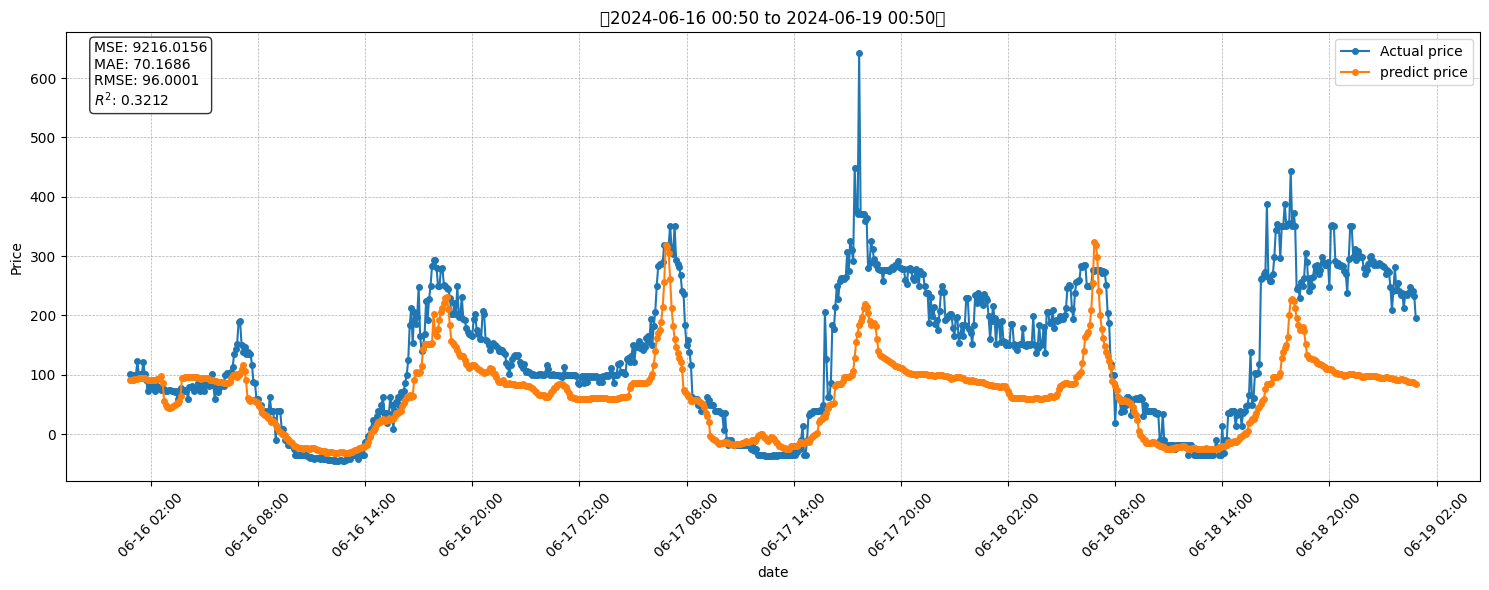

C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  plt.tight_layout()
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


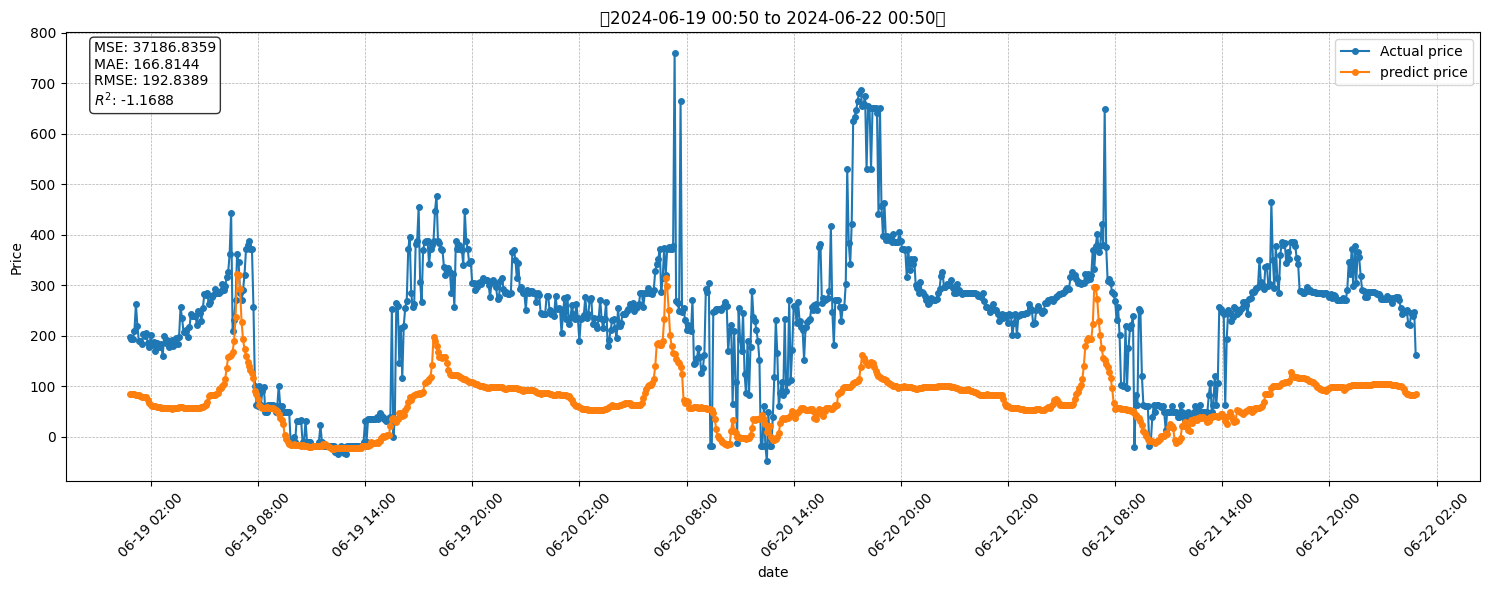

C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  plt.tight_layout()
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


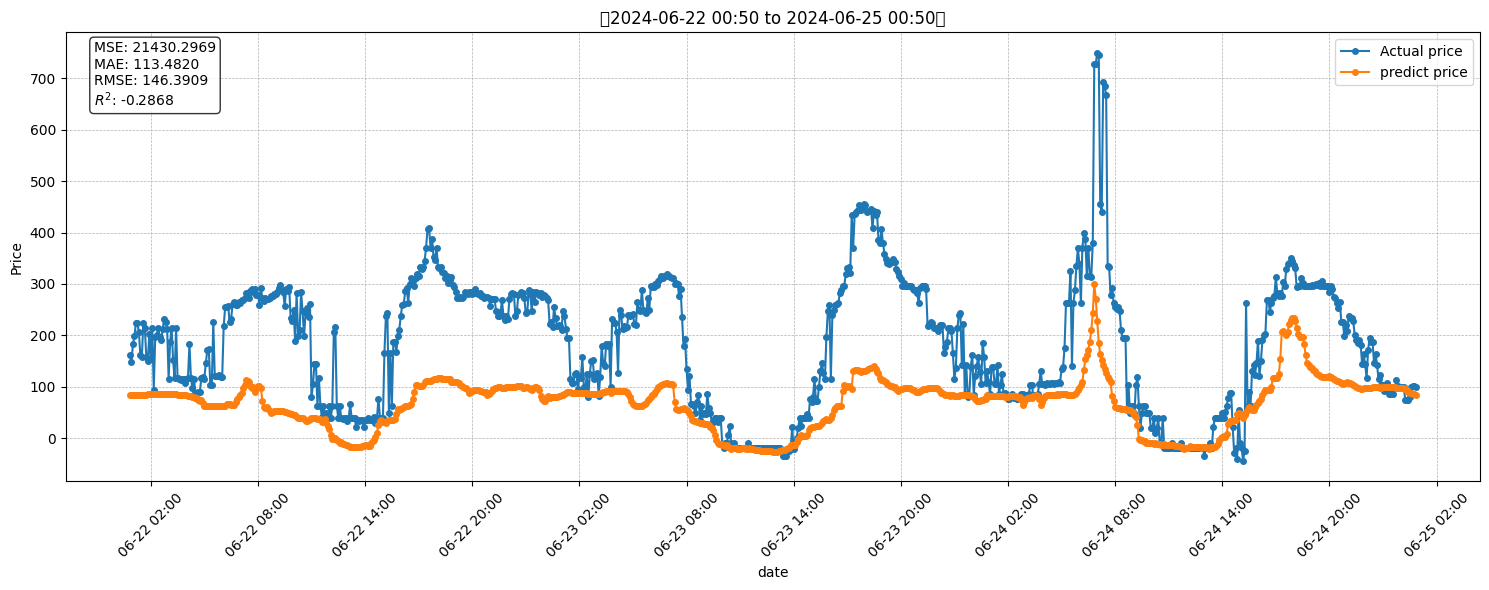

C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  plt.tight_layout()
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


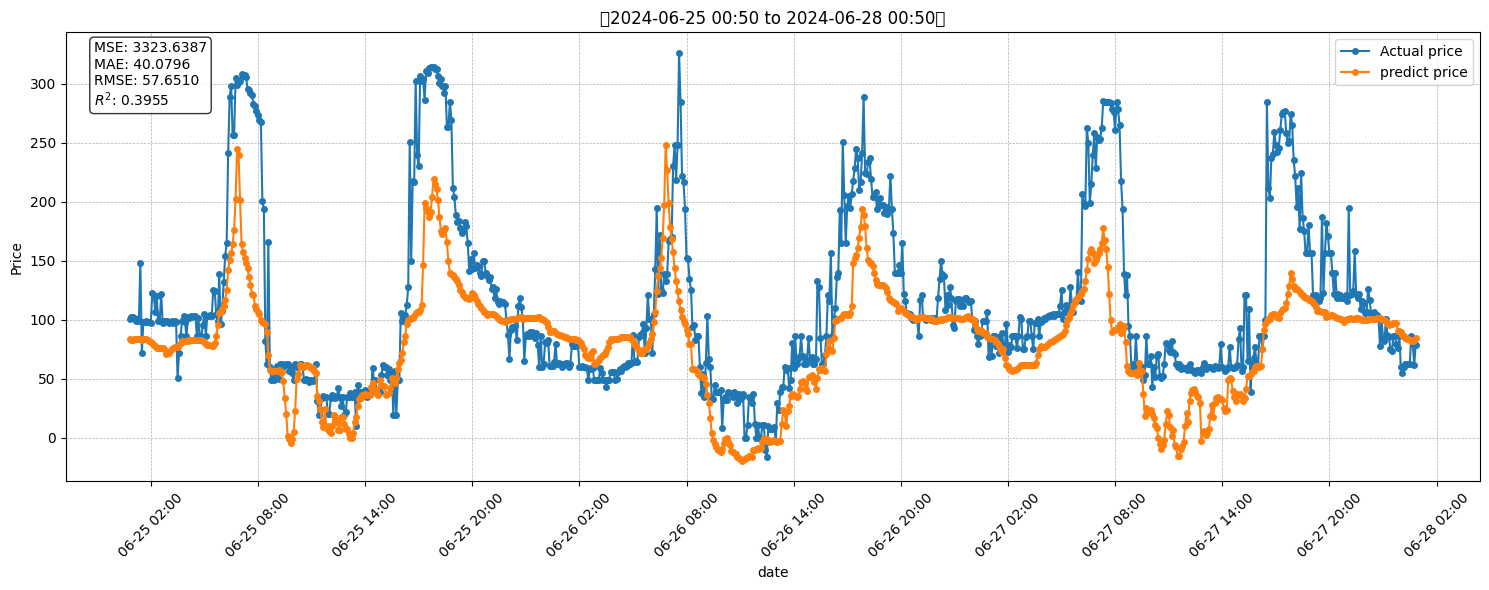

C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  plt.tight_layout()
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


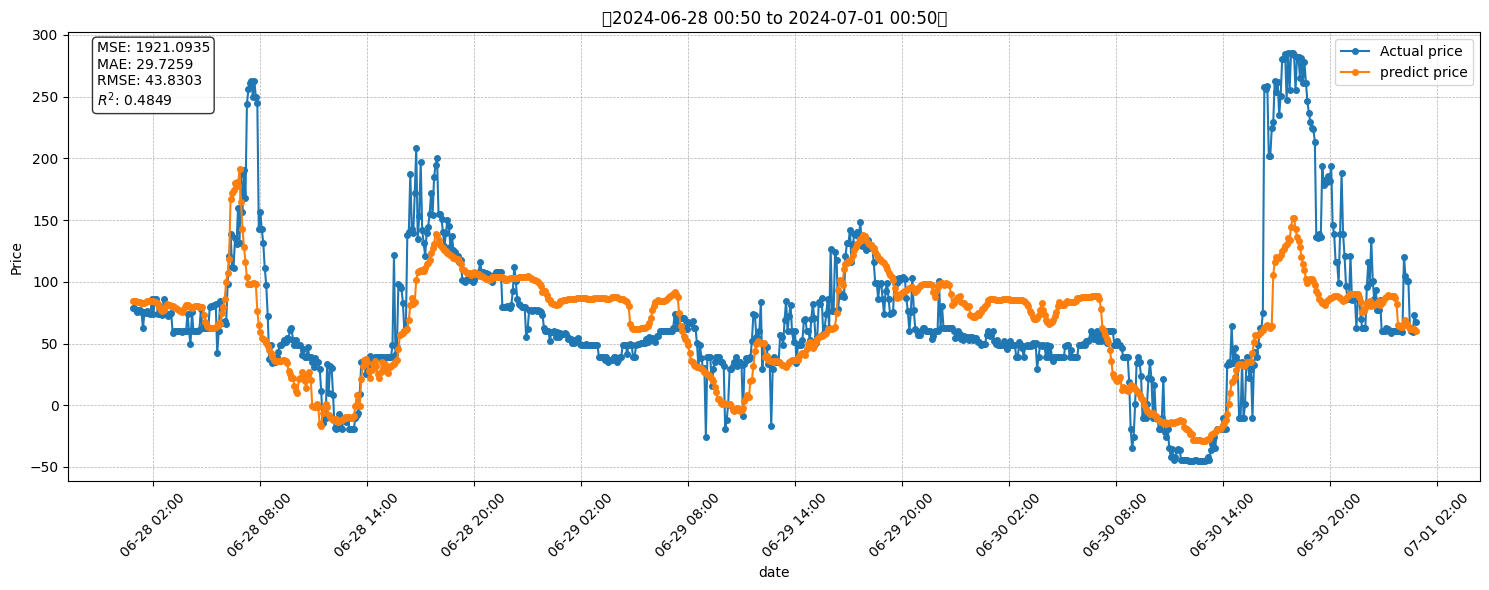

C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  plt.tight_layout()
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


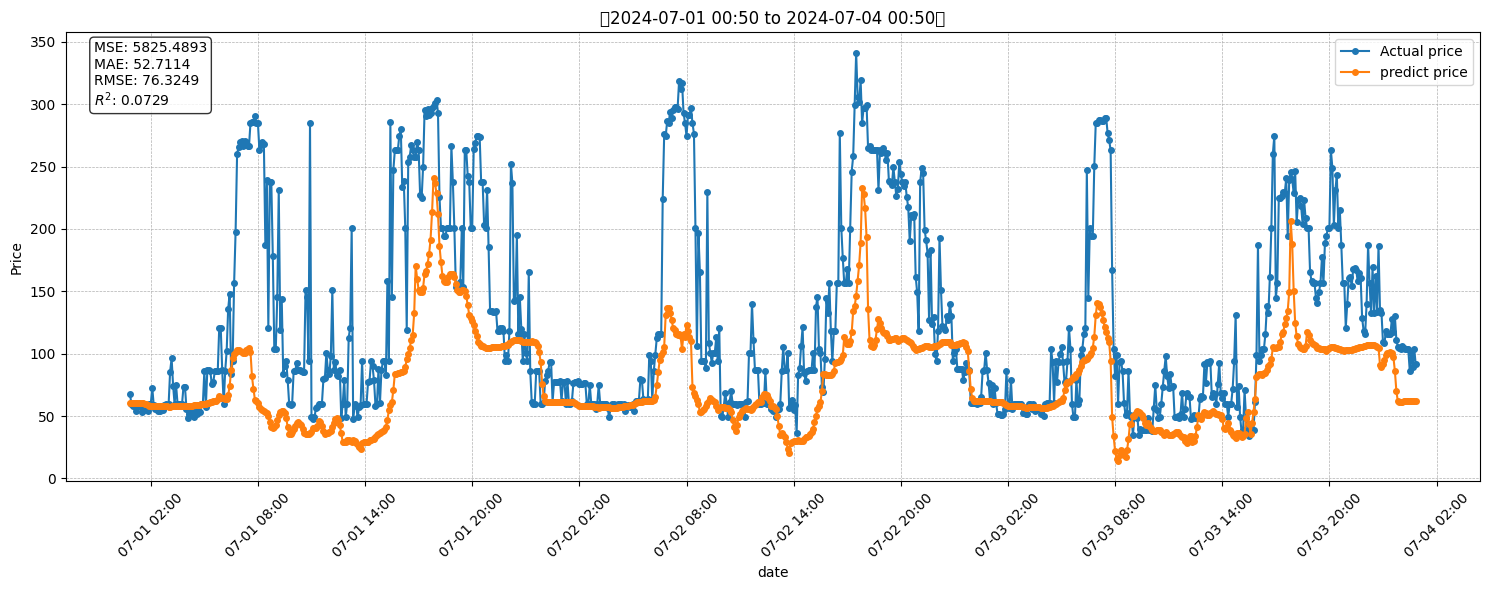

C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  plt.tight_layout()
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


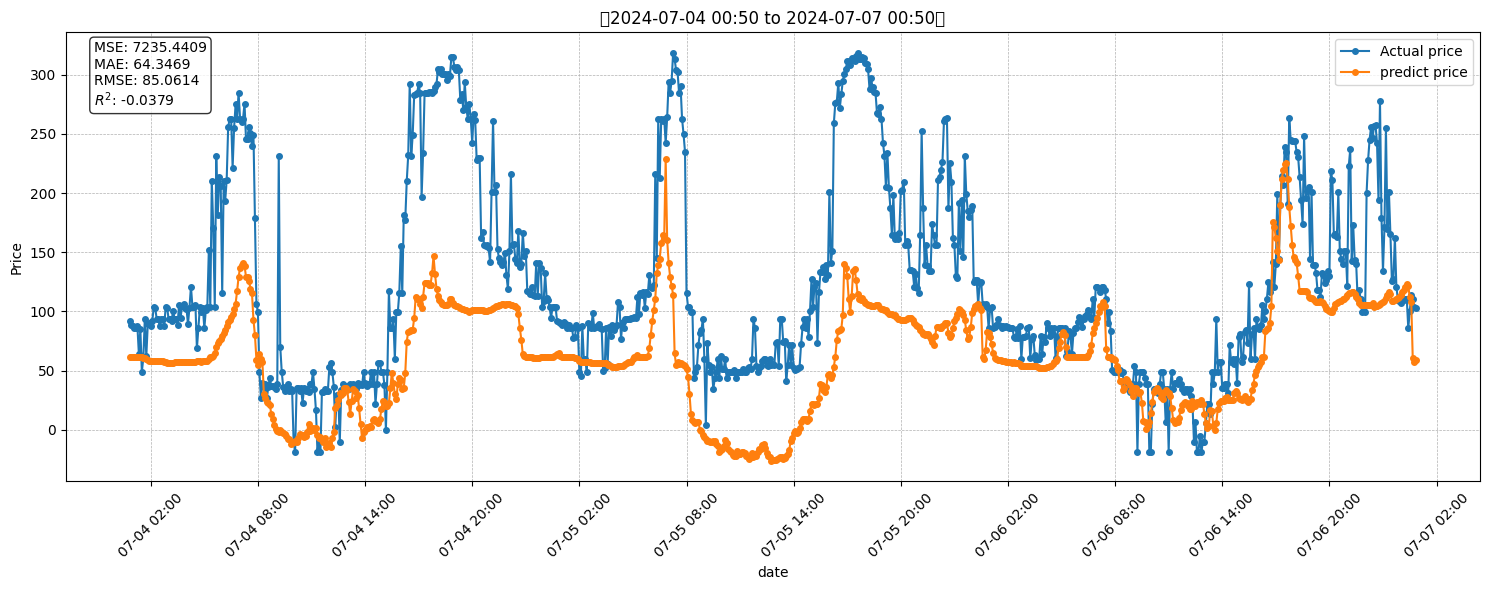

C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  plt.tight_layout()
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


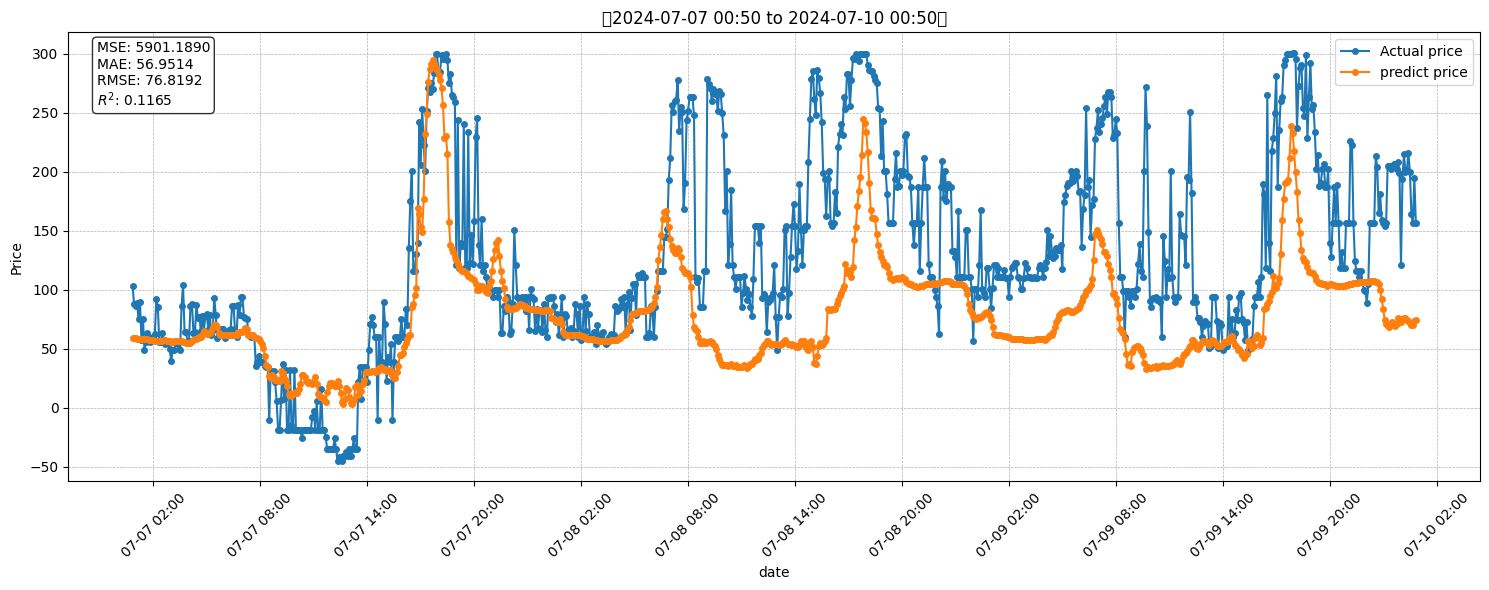

C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  plt.tight_layout()
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


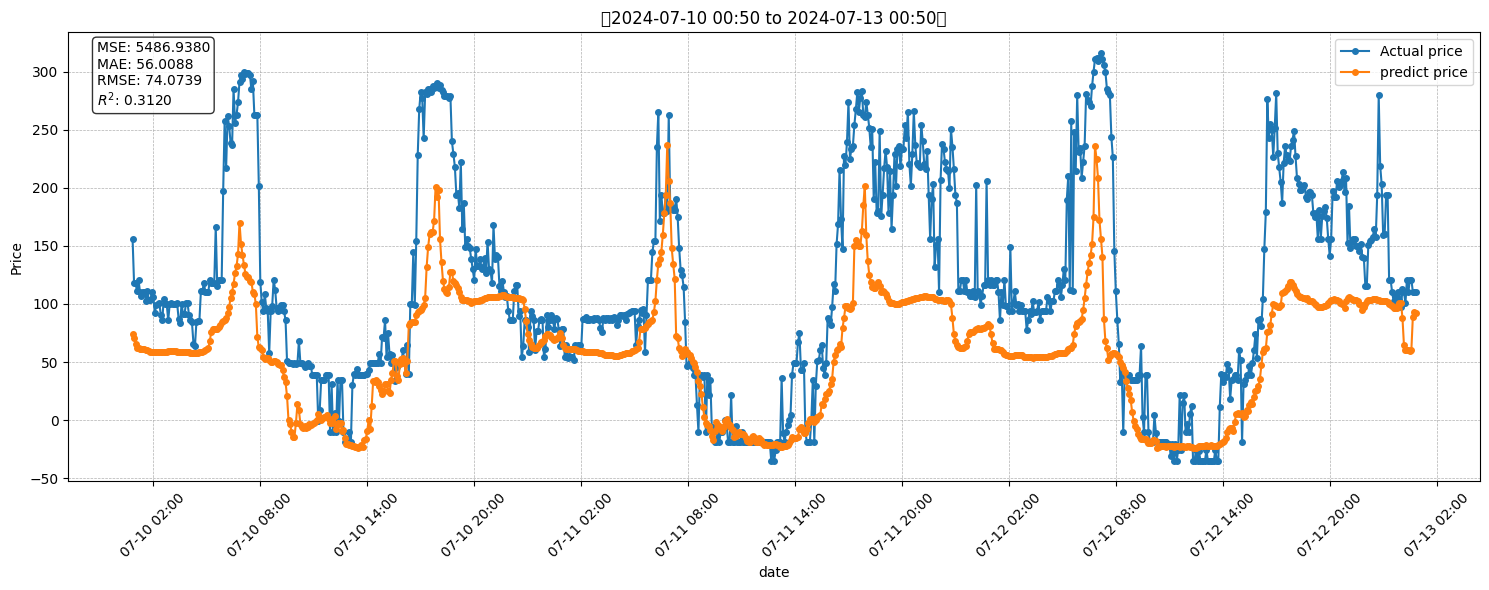

C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  plt.tight_layout()
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


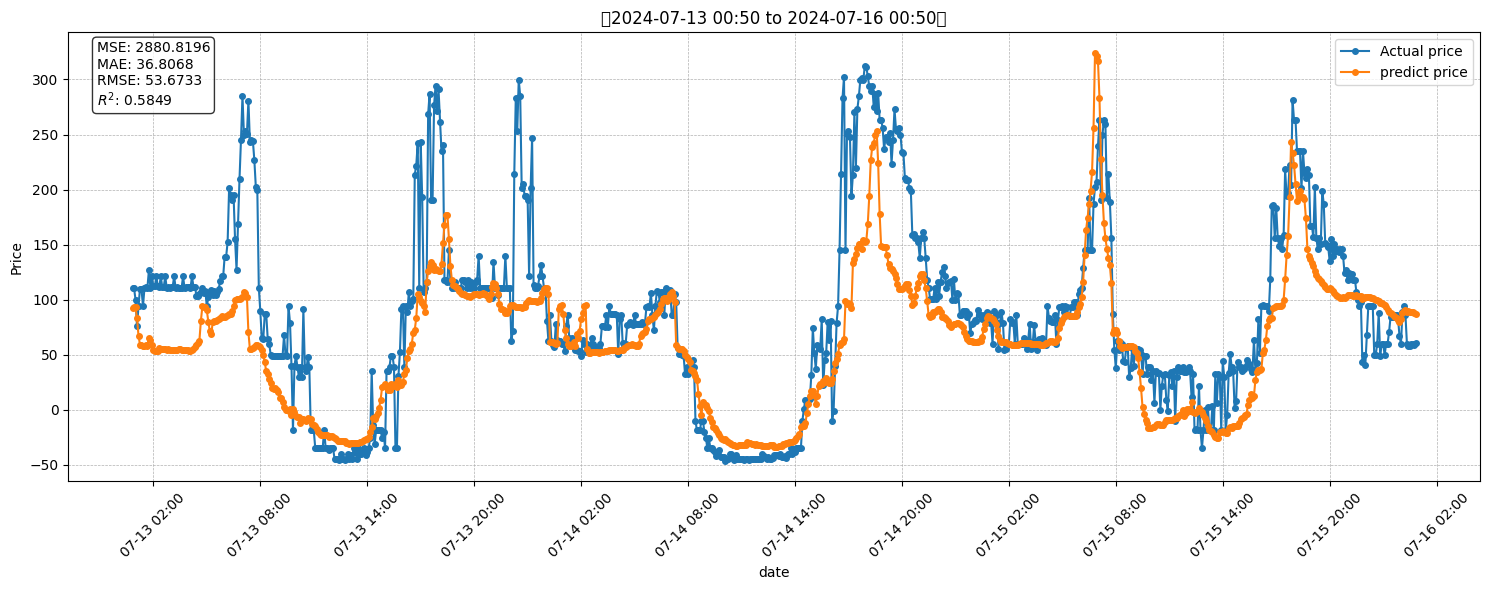

C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  plt.tight_layout()
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


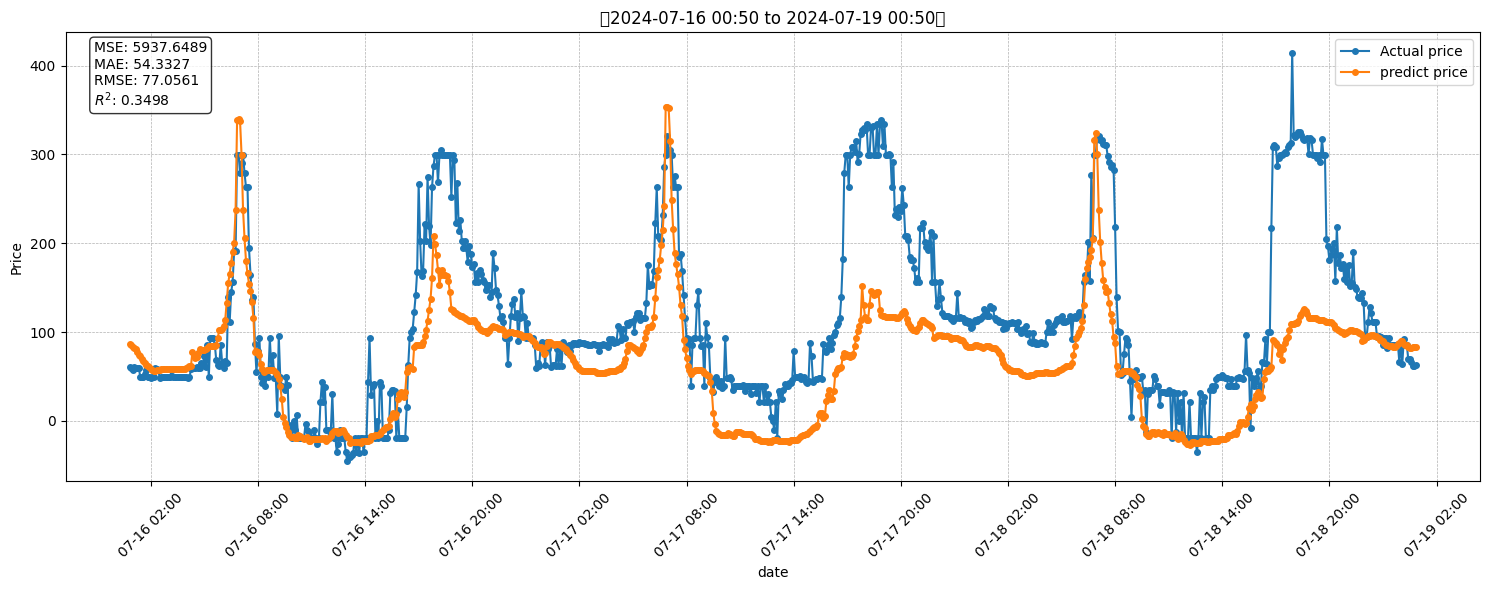

C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  plt.tight_layout()
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


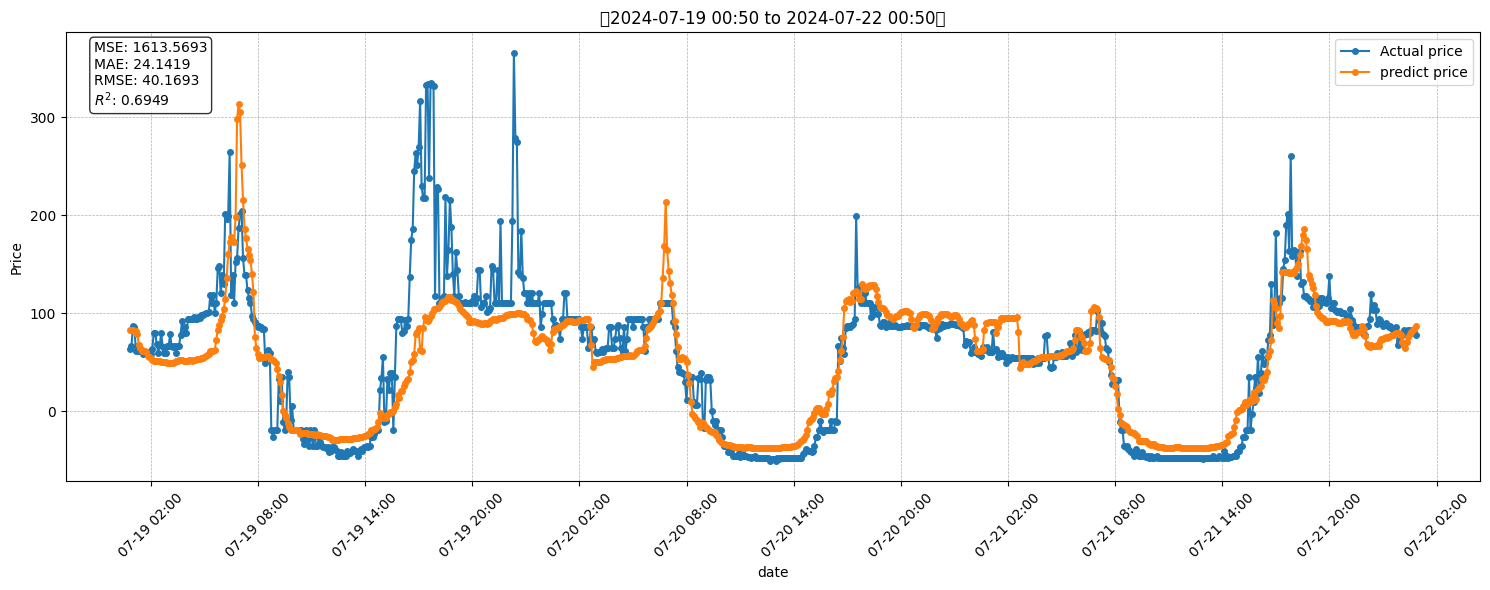

C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  plt.tight_layout()
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


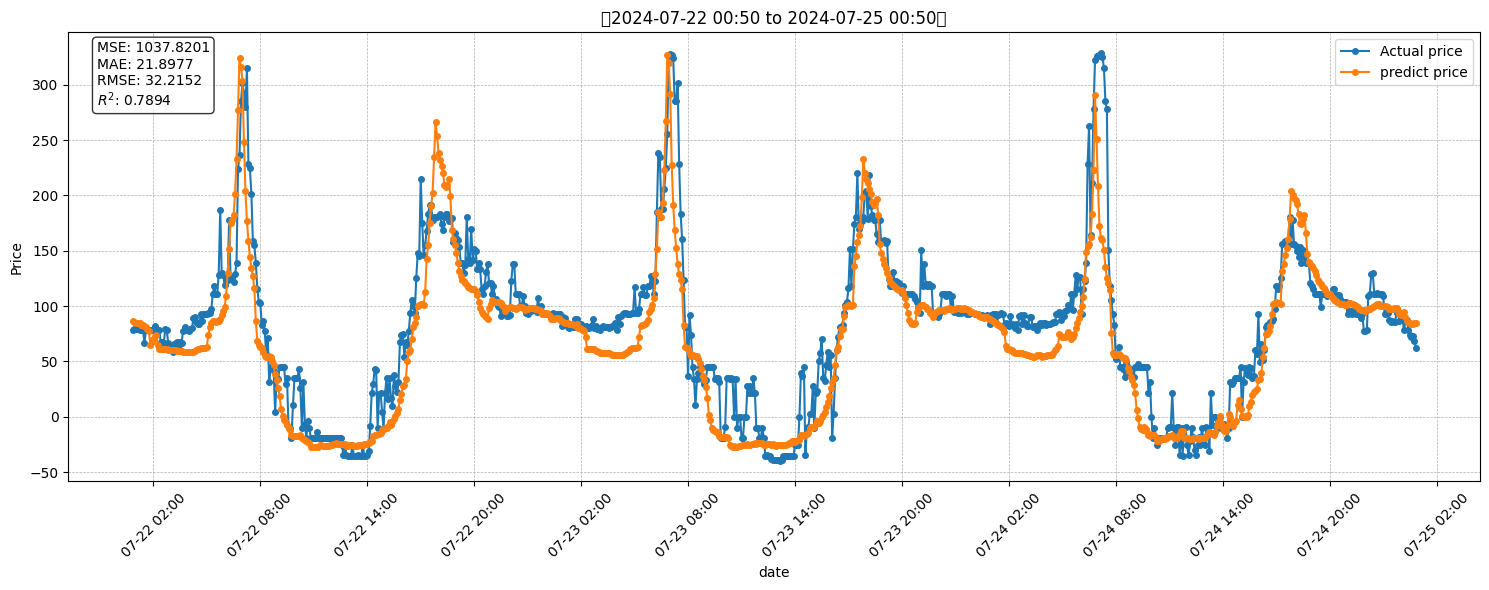

C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  plt.tight_layout()
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


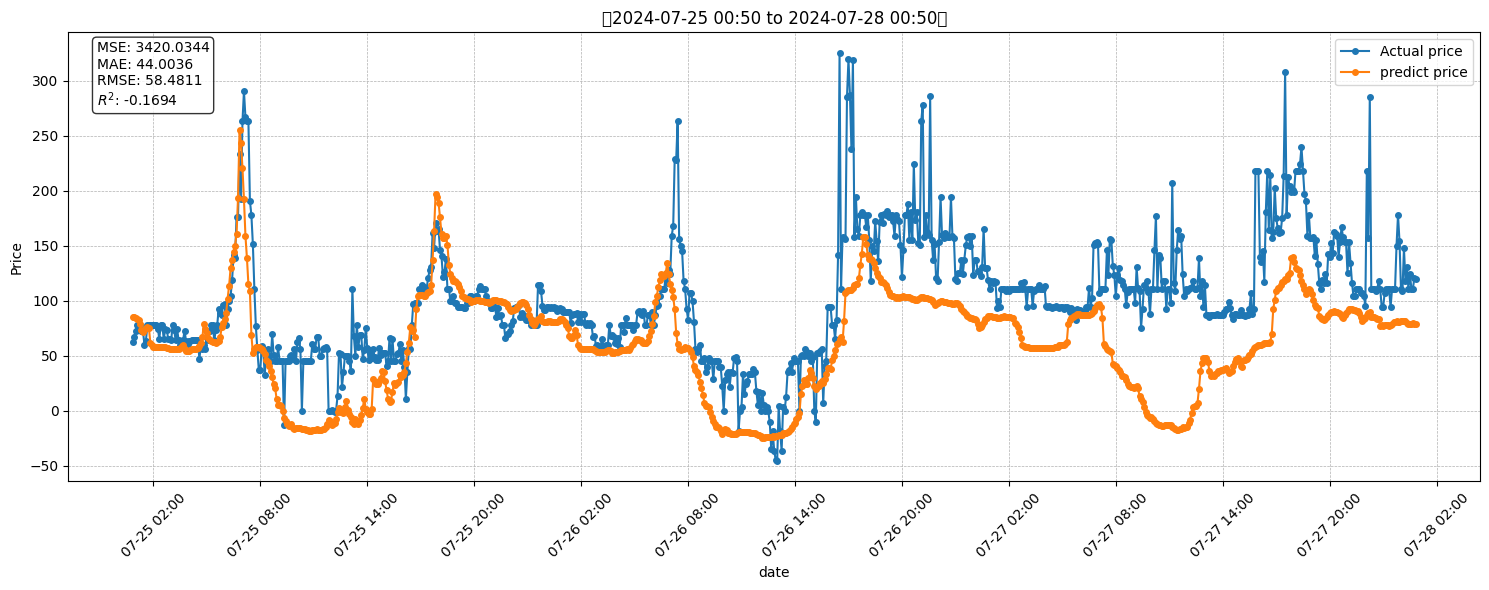

C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  plt.tight_layout()
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


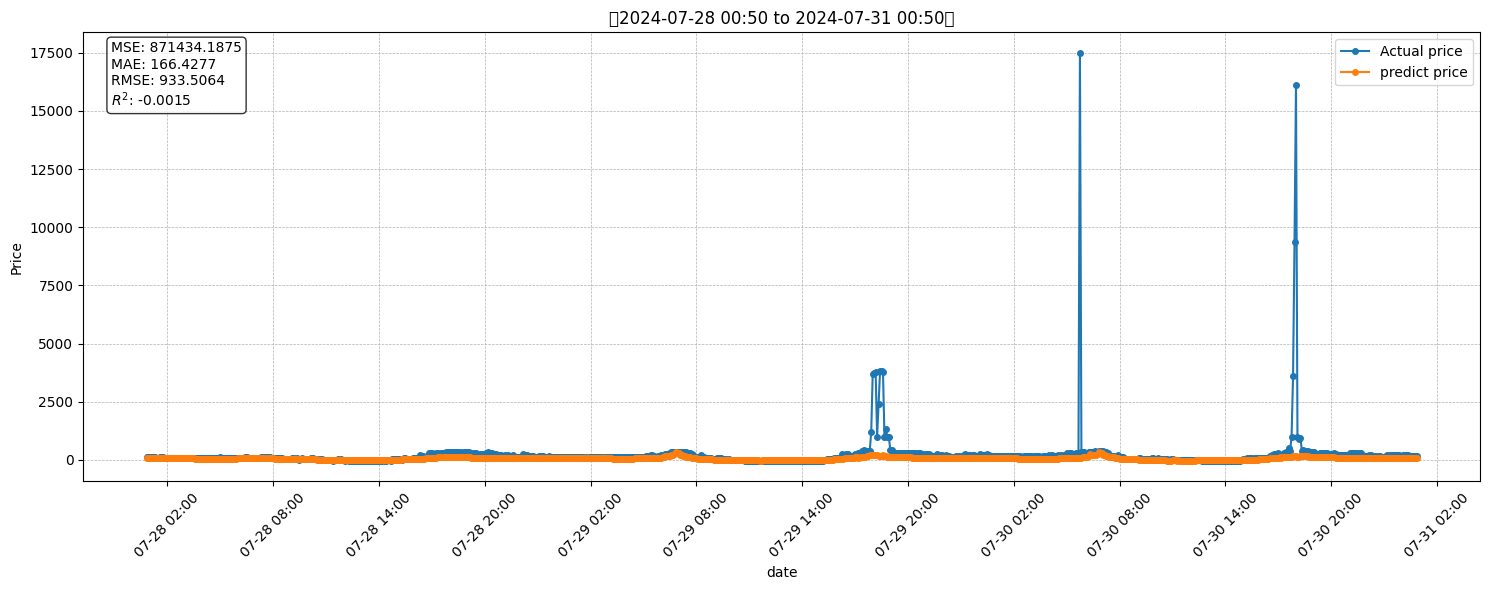

C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  plt.tight_layout()
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


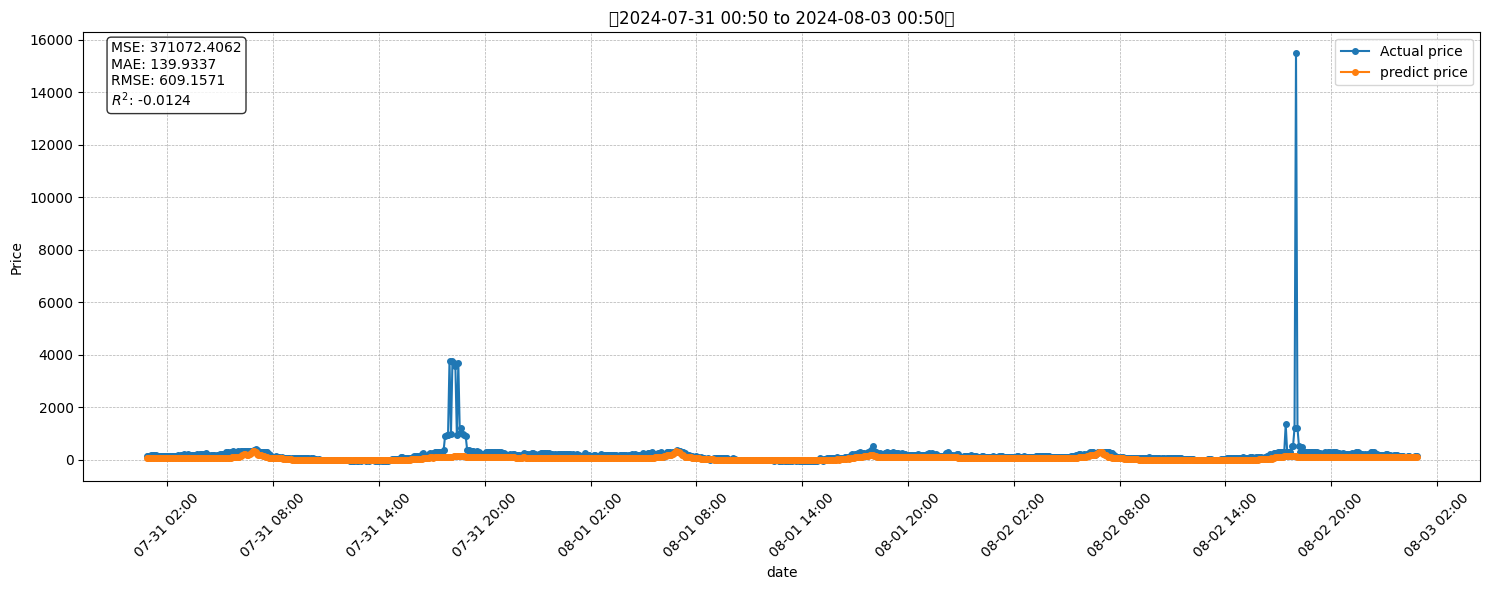

C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9364\32975654.py:25: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  plt.tight_layout()
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


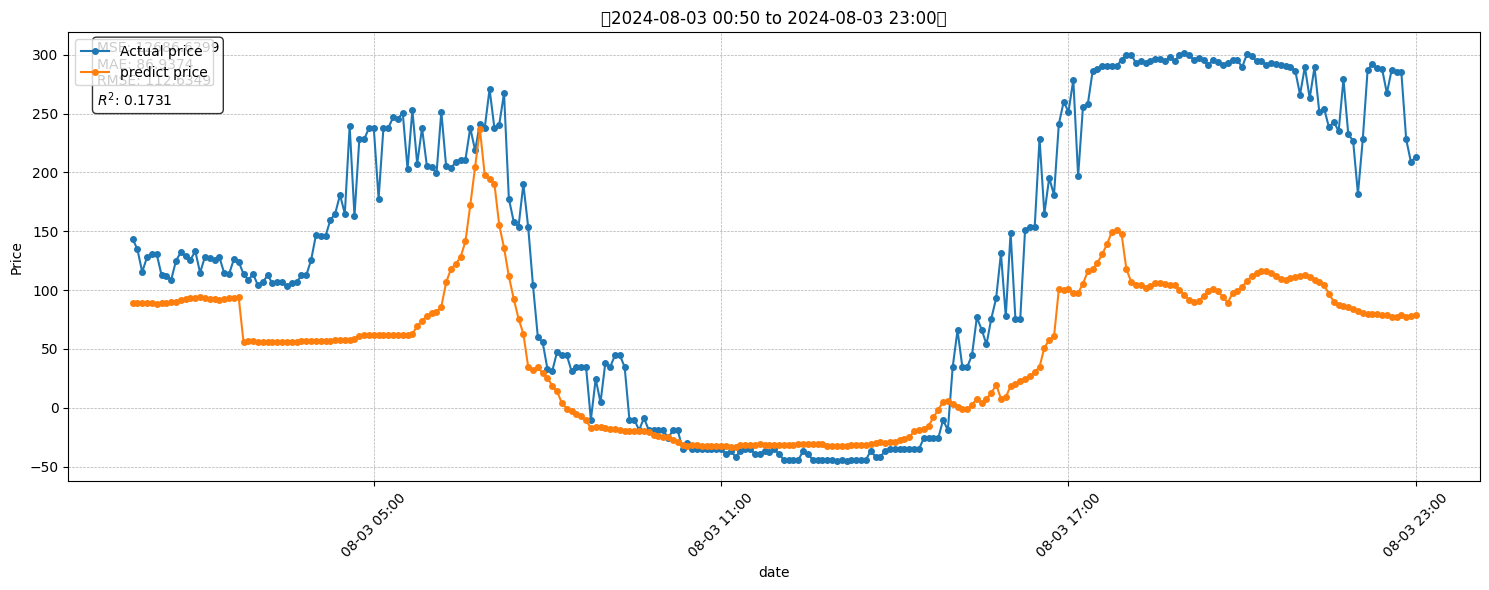

In [46]:

from datetime import timedelta


start_date = results_df.index.min()
end_date = results_df.index.max()

current_date = start_date
while current_date <= end_date:
    period_end = min(current_date + pd.Timedelta(days=3), end_date)
    plot_three_day_comparison(results_df, current_date, period_end)
    current_date += pd.Timedelta(days=3)
